In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
import os
from utils.utils import HelperFunctions
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
helpers = HelperFunctions()

In [5]:
country_name = 'croatia'
lhc_sampled_data_path = 'lhc_sampled_data'
attributes_csv_path = os.path.join(lhc_sampled_data_path, f'lhp_sampled_{country_name}_attributes.csv')
targets_csv_path = os.path.join(lhc_sampled_data_path, f'lhp_sampled_{country_name}_targets.csv')

## Let's start by cleaning the attributes data before merging the target variables.

In [6]:
df_attributes = pd.read_csv(attributes_csv_path)
print('Attributes df initial shape: ', df_attributes.shape)
df_attributes.head()

Attributes df initial shape:  (100, 2035)


,id,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,avgmass_lvst_animal_goats_kg,avgmass_lvst_animal_horses_kg,avgmass_lvst_animal_mules_kg,avgmass_lvst_animal_pigs_kg,avgmass_lvst_animal_sheep_kg,climate_change_factor_gnrl_hydropower_availability,consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing,consumpinit_inen_energy_tj_per_tonne_production_cement,consumpinit_inen_energy_tj_per_tonne_production_chemicals,consumpinit_inen_energy_tj_per_tonne_production_electronics,consumpinit_inen_energy_tj_per_tonne_production_glass,consumpinit_inen_energy_tj_per_tonne_production_lime_and_carbonite,consumpinit_inen_energy_tj_per_tonne_production_metals,consumpinit_inen_energy_tj_per_tonne_production_mining,consumpinit_inen_energy_tj_per_tonne_production_paper,consumpinit_inen_energy_tj_per_tonne_production_plastic,consumpinit_inen_energy_tj_per_tonne_production_recycled_glass,consumpinit_inen_energy_tj_per_tonne_production_recycled_metals,consumpinit_inen_energy_tj_per_tonne_production_recycled_paper,consumpinit_inen_energy_tj_per_tonne_production_recycled_plastic,consumpinit_inen_energy_tj_per_tonne_production_recycled_rubber_and_leather,consumpinit_inen_energy_tj_per_tonne_production_recycled_textiles,consumpinit_inen_energy_tj_per_tonne_production_recycled_wood,consumpinit_inen_energy_tj_per_tonne_production_rubber_and_leather,consumpinit_inen_energy_tj_per_tonne_production_textiles,consumpinit_inen_energy_tj_per_tonne_production_wood,consumpinit_inen_energy_total_pj_agriculture_and_livestock,consumpinit_scoe_gj_per_hh_residential_elec_appliances,consumpinit_scoe_gj_per_hh_residential_heat_energy,consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_elec_appliances,consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_heat_energy,...,ratio_agrc_below_ground_to_above_ground_biomass_pulses,ratio_agrc_below_ground_to_above_ground_biomass_rice,ratio_agrc_below_ground_to_above_ground_biomass_tubers,ratio_lsmm_n2_to_n2o,regressionb_agrc_above_ground_residue_cereals_kg_per_ha,regressionb_agrc_above_ground_residue_other_annual_kg_per_ha,regressionb_agrc_above_ground_residue_pulses_kg_per_ha,regressionb_agrc_above_ground_residue_rice_kg_per_ha,regressionb_agrc_above_ground_residue_tubers_kg_per_ha,regressionm_agrc_above_ground_residue_cereals_kg_per_ha,regressionm_agrc_above_ground_residue_other_annual_kg_per_ha,regressionm_agrc_above_ground_residue_pulses_kg_per_ha,regressionm_agrc_above_ground_residue_rice_kg_per_ha,regressionm_agrc_above_ground_residue_tubers_kg_per_ha,strategy_id,cost_enfu_fuel_ammonia_usd_per_tonne,ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia,ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia,ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia,ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia,exports_enfu_pj_fuel_ammonia,frac_enfu_fuel_demand_imported_pj_fuel_ammonia,nemomod_entc_capital_cost_fp_ammonia_production_mm_usd_per_gw,nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw,nemomod_entc_emissions_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_tonne_co2_per_tj,nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2,nemomod_entc_fixed_cost_fp_ammonia_production_mm_usd_per_gw,nemomod_entc_fixed_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw,nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_electricity,nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_hydrogen,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensit

In [7]:
df_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2035 entries, id to nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
dtypes: float64(2034), int64(1)
memory usage: 1.6 MB


### Check NaNs

In [8]:
# Check for cols with null values
null_columns = helpers.check_null_values(df_attributes)

No null values found


In [9]:
df_attributes[null_columns].head()

""
0
1
2
3
4


In [10]:
# For now we drop if there is any NaN. It seems our attributes do not have NaNs so this is just for safety
df_attributes.dropna(axis=0, inplace=True)
print('Attributes df shape after using dropna: ', df_attributes.shape)

Attributes df shape after using dropna:  (100, 2035)


In [11]:
# Double check
helpers.check_null_values(df_attributes)

No null values found


[]

### Check cols that have the same value repeated

- If they are all 0 they can be dropped.
- If they have the same number they will not contribute to the variation we need.

In [12]:
# Check for columns that have the same value in all rows
cols_with_repeated_values = helpers.check_cols_with_same_val(df_attributes)

The following columns have repeated values across all rows: 
 ['consumpinit_inen_energy_tj_per_tonne_production_wood', 'consumpinit_scoe_tj_per_mmmgdp_other_se_elec_appliances', 'consumpinit_scoe_tj_per_mmmgdp_other_se_heat_energy', 'ef_fgtv_production_fugitive_tonne_ch4_per_m3_fuel_coal', 'ef_fgtv_production_fugitive_tonne_co2_per_m3_fuel_coal', 'ef_fgtv_production_venting_tonne_n2o_per_m3_fuel_oil', 'ef_fgtv_transmission_tonne_n2o_per_m3_fuel_oil', 'ef_ippu_tonne_c2f6_per_mmm_gdp_product_use_ods_other', 'ef_ippu_tonne_c2f6_per_tonne_production_chemicals', 'ef_ippu_tonne_c2f6_per_tonne_production_electronics', 'ef_ippu_tonne_c2f6_per_tonne_production_metals', 'ef_ippu_tonne_c2h3f3_per_tonne_production_chemicals', 'ef_ippu_tonne_c2hf5_per_tonne_production_chemicals', 'ef_ippu_tonne_c3f8_per_tonne_production_chemicals', 'ef_ippu_tonne_c3f8_per_tonne_production_electronics', 'ef_ippu_tonne_c3h2f6_per_mmm_gdp_product_use_ods_other', 'ef_ippu_tonne_c3h2f6_per_mmm_gdp_product_use_ods_refrig

In [13]:
df_attributes.drop(columns=cols_with_repeated_values, inplace=True)
print('Attributes df shape after dropping cols with all same values: ', df_attributes.shape)

Attributes df shape after dropping cols with all same values:  (100, 1473)


In [14]:
# Double Check elimination
cols_with_repeated_values = helpers.check_cols_with_same_val(df_attributes)

The following columns have repeated values across all rows: 
 []
Amount of cols with repeated values:  0


## Now let's move to analyze the target variables

In [15]:
df_target_vars = pd.read_csv(targets_csv_path)
df_target_vars.head()

,id,AG_Livestock_CH4,AG_Livestock_N2O,AG_Crops_CO2,AG_Crops_CH4,AG_Crops_N2O,EN_Building_CO2,EN_Building_CH4,EN_Building_N2O,EN_ElectricityHeat_CO2,EN_ElectricityHeat_CH4,EN_ElectricityHeat_N2O,EN_FugitiveEmissions_CO2,EN_FugitiveEmissions_CH4,EN_FugitiveEmissions_N2O,EN_ManufacturingConstruction_CO2,EN_ManufacturingConstruction_CH4,EN_ManufacturingConstruction_N2O,EN_Transportation_CO2,EN_Transportation_CH4,EN_Transportation_N2O,IN_IndustrialProcesses_CO2,IN_IndustrialProcesses_CH4,IN_IndustrialProcesses_N2O,IN_IndustrialProcesses_HFCc2f6,IN_IndustrialProcesses_HFCc2h3f3,IN_IndustrialProcesses_HFCc2hf5,IN_IndustrialProcesses_HFCc3f8,IN_IndustrialProcesses_HFCc3h2f6,IN_IndustrialProcesses_HFCc3h3f5,IN_IndustrialProcesses_HFCc3hf7,IN_IndustrialProcesses_HFCc4f10,IN_IndustrialProcesses_HFCc4f6,IN_IndustrialProcesses_HFCc4h5f5,IN_IndustrialProcesses_HFCc5f12,IN_IndustrialProcesses_HFCc5f8,IN_IndustrialProcesses_HFCc5h2f10,IN_IndustrialProcesses_HFCc6f14,IN_IndustrialProcesses_HFCcc4f8,IN_IndustrialProcesses_HFCcf4,IN_IndustrialProcesses_HFCch2f2,IN_IndustrialProcesses_HFCch2fchf2,IN_IndustrialProcesses_HFCch3cci2f,IN_IndustrialProcesses_HFCch3ccif2,IN_IndustrialProcesses_HFCch3chf2,IN_IndustrialProcesses_HFCch3f,IN_IndustrialProcesses_HFCchf2cf3,IN_IndustrialProcesses_HFCchf2chf2,IN_IndustrialProcesses_HFCchf3,IN_IndustrialProcesses_HFChfcs,IN_IndustrialProcesses_HFCother_fcs,IN_IndustrialProcesses_PFCpfcs,IN_IndustrialProcesses_SF6,Waste_SolidWaste_CO2,Waste_SolidWaste_CH4,Waste_SolidWaste_N2O,Waste_WastewaterTreatment_CH4,Waste_WastewaterTreatment_N2O,LULUCF_ForestLand_CO2,LULUCF_ForestLand_CH4,LULUCF_Deforestation_CO2,LULUCF_Deforestation_CH4,LULUCF_OrganicSoil_CO2,LULUCF_OrganicSoil_N2O
0,1,0.293190,0.231473,23.326594,1.187369,0.994199,4.307744,0.006090,0.005047,7.299362,0.007641,0.023061,0.259917,1.337733,0.000062,7.748007,0.009856,0.015350,12.592816,0.003968,0.356040,13.620661,0.028897,0.497685,0.0,0.662190,0.194583,0.0,0.0,0.0,0.0,0.0,3.105015e-10,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.034542,0.0,0.0,0.0,4.147087e-07,0.0,0.196736,0.0,0.0,1.088052,0.000008,0.000001,0.0,-1.317593,0.111083,0.011786,0.828140,0.770557,4.027556,0.241063,0.068106,0.664543,0.022903,4.771070
1,2,0.009929,0.289614,78.273000,0.869895,0.351969,9.354430,0.006263,0.096383,3.395921,0.006601,0.010539,0.183590,0.155152,0.000049,4.502495,0.005428,0.013366,2.413686,0.001866,0.016720,6.049081,0.059347,2.731309,0.0,0.230737,0.484725,0.0,0.0,0.0,0.0,0.0,1.458105e-09,0.0,0.0,0.000027,0.0,0.0,0.0,0.0,0.038054,0.0,0.0,0.0,3.389716e-07,0.0,0.182978,0.0,0.0,0.936495,0.000303,0.000027,0.0,0.943501,0.676180,0.052393,2.191808,0.142598,2.039361,0.055671,0.381433,0.150161,0.103541,17.544440
2,3,0.084564,0.139065,44.981280,1.260332,0.761880,18.915926,0.022332,0.059248,72.939014,0.062195,0.073483,0.905847,2.556524,0.000282,1.720910,0.006599,0.010684,87.811416,0.111609,0.178474,2.638859,0.025798,2.119043,0.0,0.205732,0.087291,0.0,0.0,0.0,0.0,0.0,5.978432e-10,0.0,0.0,0.000006,0.0,0.0,0.0,0.0,0.072264,0.0,0.0,0.0,1.344686e-07,0.0,0.066298,0.0,0.0,0.431585,0.000199,0.000006,0.0,0.764725,0.580193,0.022370,0.521712,0.132777,-2.080179,0.185738,0.024190,0.164943,0.117854,8.549432
3,4,0.089139,0.169623,23.006985,0.345429,2.091302,4.897107,0.006941,0.024766,7.299362,0.007641,0.023061,0.259917,1.337733,0.000062,5.535815,0.005708,0.011603,3.706208,0.008749,0.037700,6.437281,0.032141,5.643020,0.0,0.018988,0.238921,0.0,0.0,0.0,0.0,0.0,3.743595e-09,0.0,0.0,0.000026,0.0,0.0,0.0,0.0,0.006279,0.0,0.0,0.0,4.004662e-07,0.0,0.011206,0.0,0.0,0.275394,0.000239,0.000026,0.0,0.513284,0.182666,0.018340,0.707272,0.027622,5.688578,0.167962,0.037159,0.127554,0.030958,6.081237
4,5,0.040506,0.229474,28.048034,0.263806,2.032316,3.807333,0.003157,0.008766,4.893175,0.003186,0.015299,0.365402,2.481554,0.000054,8.162800,0.007340,0.025376,25.164052,0.025544,0.307553,5.729939,0.036404,2.074149,0.0,0.051810,0.351927,0.0,0.0,0.0,0.0,0.0,5.313522e-09,0.0,0.0,0.000031,0.0,0.0,0.0,0.0,0.104639,0.0,0.0,0.0,5.100578e-07,

In [16]:
# Checkinng null values
helpers.check_null_values(df_target_vars)

No null values found


[]

In [17]:
helpers.check_cols_with_same_val(df_target_vars)

The following columns have repeated values across all rows: 
 ['IN_IndustrialProcesses_HFCc2f6', 'IN_IndustrialProcesses_HFCc3f8', 'IN_IndustrialProcesses_HFCc3h2f6', 'IN_IndustrialProcesses_HFCc3h3f5', 'IN_IndustrialProcesses_HFCc3hf7', 'IN_IndustrialProcesses_HFCc4f10', 'IN_IndustrialProcesses_HFCc4h5f5', 'IN_IndustrialProcesses_HFCc5f12', 'IN_IndustrialProcesses_HFCc5h2f10', 'IN_IndustrialProcesses_HFCc6f14', 'IN_IndustrialProcesses_HFCcc4f8', 'IN_IndustrialProcesses_HFCcf4', 'IN_IndustrialProcesses_HFCch2fchf2', 'IN_IndustrialProcesses_HFCch3cci2f', 'IN_IndustrialProcesses_HFCch3ccif2', 'IN_IndustrialProcesses_HFCch3f', 'IN_IndustrialProcesses_HFCchf2chf2', 'IN_IndustrialProcesses_HFCchf3', 'IN_IndustrialProcesses_SF6']
Amount of cols with repeated values:  19


['IN_IndustrialProcesses_HFCc2f6',
 'IN_IndustrialProcesses_HFCc3f8',
 'IN_IndustrialProcesses_HFCc3h2f6',
 'IN_IndustrialProcesses_HFCc3h3f5',
 'IN_IndustrialProcesses_HFCc3hf7',
 'IN_IndustrialProcesses_HFCc4f10',
 'IN_IndustrialProcesses_HFCc4h5f5',
 'IN_IndustrialProcesses_HFCc5f12',
 'IN_IndustrialProcesses_HFCc5h2f10',
 'IN_IndustrialProcesses_HFCc6f14',
 'IN_IndustrialProcesses_HFCcc4f8',
 'IN_IndustrialProcesses_HFCcf4',
 'IN_IndustrialProcesses_HFCch2fchf2',
 'IN_IndustrialProcesses_HFCch3cci2f',
 'IN_IndustrialProcesses_HFCch3ccif2',
 'IN_IndustrialProcesses_HFCch3f',
 'IN_IndustrialProcesses_HFCchf2chf2',
 'IN_IndustrialProcesses_HFCchf3',
 'IN_IndustrialProcesses_SF6']

In [18]:
helpers.get_lowest_variance_cols(df_target_vars)

36 out of 64 variables with variance < 0.01
['AG_Livestock_CH4', 'EN_Building_CH4', 'EN_Building_N2O', 'EN_ElectricityHeat_CH4', 'EN_FugitiveEmissions_N2O', 'EN_ManufacturingConstruction_CH4', 'EN_ManufacturingConstruction_N2O', 'EN_Transportation_CH4', 'IN_IndustrialProcesses_CH4', 'IN_IndustrialProcesses_HFCc2f6', 'IN_IndustrialProcesses_HFCc3f8', 'IN_IndustrialProcesses_HFCc3h2f6', 'IN_IndustrialProcesses_HFCc3h3f5', 'IN_IndustrialProcesses_HFCc3hf7', 'IN_IndustrialProcesses_HFCc4f10', 'IN_IndustrialProcesses_HFCc4f6', 'IN_IndustrialProcesses_HFCc4h5f5', 'IN_IndustrialProcesses_HFCc5f12', 'IN_IndustrialProcesses_HFCc5f8', 'IN_IndustrialProcesses_HFCc5h2f10', 'IN_IndustrialProcesses_HFCc6f14', 'IN_IndustrialProcesses_HFCcc4f8', 'IN_IndustrialProcesses_HFCcf4', 'IN_IndustrialProcesses_HFCch2f2', 'IN_IndustrialProcesses_HFCch2fchf2', 'IN_IndustrialProcesses_HFCch3cci2f', 'IN_IndustrialProcesses_HFCch3ccif2', 'IN_IndustrialProcesses_HFCch3chf2', 'IN_IndustrialProcesses_HFCch3f', 'IN_Ind

['AG_Livestock_CH4',
 'EN_Building_CH4',
 'EN_Building_N2O',
 'EN_ElectricityHeat_CH4',
 'EN_FugitiveEmissions_N2O',
 'EN_ManufacturingConstruction_CH4',
 'EN_ManufacturingConstruction_N2O',
 'EN_Transportation_CH4',
 'IN_IndustrialProcesses_CH4',
 'IN_IndustrialProcesses_HFCc2f6',
 'IN_IndustrialProcesses_HFCc3f8',
 'IN_IndustrialProcesses_HFCc3h2f6',
 'IN_IndustrialProcesses_HFCc3h3f5',
 'IN_IndustrialProcesses_HFCc3hf7',
 'IN_IndustrialProcesses_HFCc4f10',
 'IN_IndustrialProcesses_HFCc4f6',
 'IN_IndustrialProcesses_HFCc4h5f5',
 'IN_IndustrialProcesses_HFCc5f12',
 'IN_IndustrialProcesses_HFCc5f8',
 'IN_IndustrialProcesses_HFCc5h2f10',
 'IN_IndustrialProcesses_HFCc6f14',
 'IN_IndustrialProcesses_HFCcc4f8',
 'IN_IndustrialProcesses_HFCcf4',
 'IN_IndustrialProcesses_HFCch2f2',
 'IN_IndustrialProcesses_HFCch2fchf2',
 'IN_IndustrialProcesses_HFCch3cci2f',
 'IN_IndustrialProcesses_HFCch3ccif2',
 'IN_IndustrialProcesses_HFCch3chf2',
 'IN_IndustrialProcesses_HFCch3f',
 'IN_IndustrialProcesse

## Addressing outliers
Using IQR to cap the outliers

In [19]:
df_attributes_capped = helpers.cap_outliers_iqr(df_attributes)

In [20]:
print(df_attributes.shape)
print(df_attributes_capped.shape)

(100, 1473)
(100, 1473)


In [21]:
df_target_vars_capped = helpers.cap_outliers_iqr(df_target_vars)

In [22]:
print(df_target_vars.shape)
print(df_target_vars_capped.shape)

(100, 64)
(100, 64)


<Axes: >

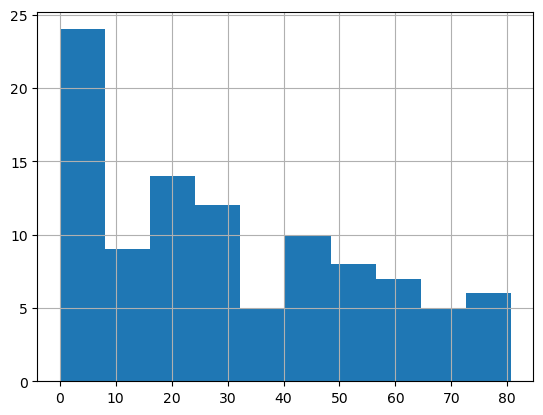

In [23]:
df_target_vars_capped['AG_Crops_CO2'].hist()

## ML Part

### Feature importance with RF (Testing with FGTV and without dealing with outliers)

In [24]:
X = df_attributes_capped.drop(columns=['id'])
y = df_target_vars_capped['AG_Crops_CO2']

In [25]:
y.var()

564.9600361936484

In [26]:
y.std()

23.768887988158983

In [27]:
y.quantile(0.75) - y.quantile(0.25)

39.019542192551484

<Axes: >

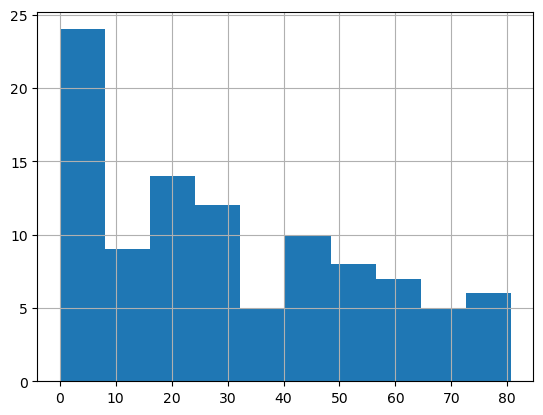

In [28]:
y.hist()

Target variable stats:
Var: 564.9600361936484, StDev: 23.768887988158983, IQR: 39.019542192551484
Evaluation Metrics:
- Mean Squared Error: 541.6964430317421
- R2 Score: -0.6128491595132621


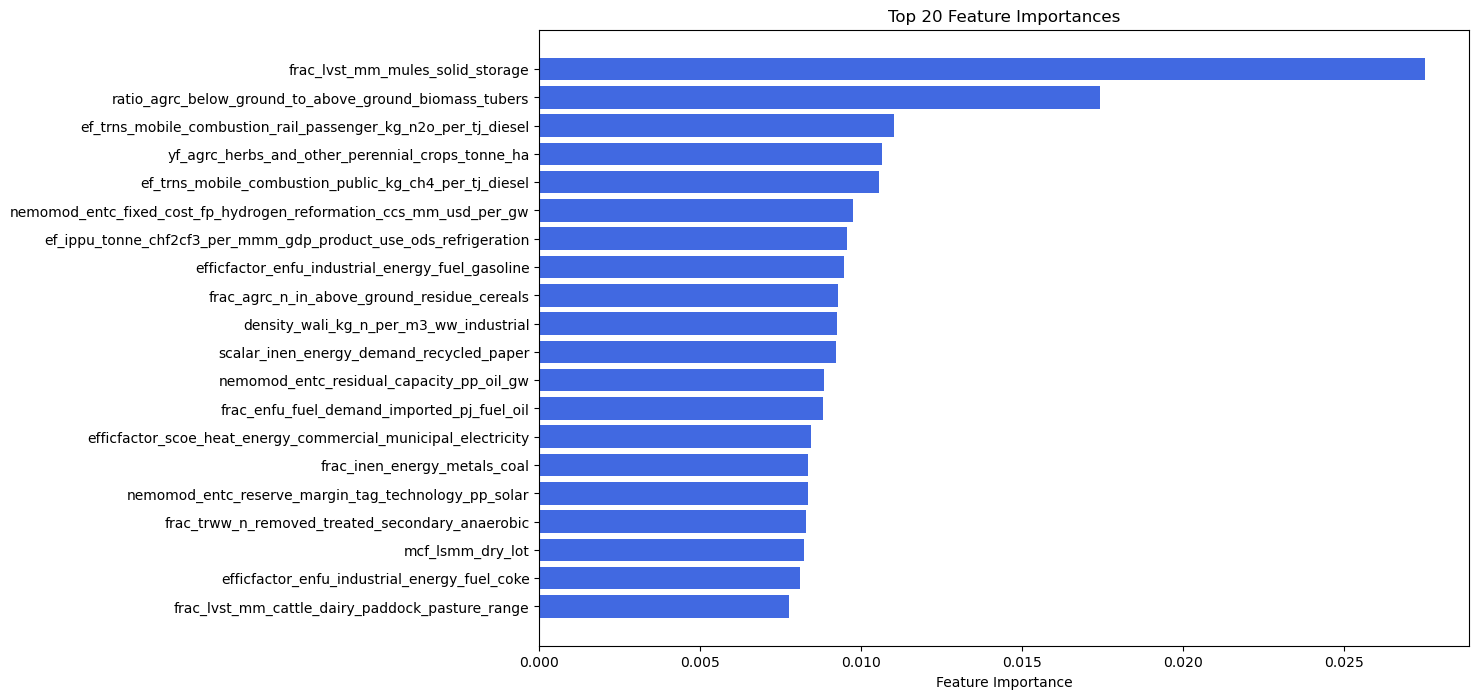

In [33]:
from utils.utils import FeatureImportanceRF

feature_importance_rd = FeatureImportanceRF(X, y)
feature_names = feature_importance_rd.run_feature_selector()

#